In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx as dx
from scipy.signal import sawtooth, square
from scipy.fft import rfft, rfftfreq, irfft
from time import sleep
import sounddevice as sd
from scipy.io.wavfile import write
import os
import time
from scipy import integrate

class MyDAQ:
    def __init__(self):
        self.__samplerate = None
        self.__name = None

    @property
    def samplerate(self) -> int:
        return self.__samplerate

    @samplerate.setter
    def samplerate(self, newSamplerate: int) -> None:
        assert isinstance(newSamplerate, int), "Samplerate should be an integer."
        assert newSamplerate > 0, "Samplerate should be positive."
        self.__samplerate = newSamplerate

    @property
    def name(self) -> str:
        return self.__name

    @name.setter
    def name(self, newName: str) -> None:
        assert isinstance(newName, str), "Name should be a string."
        self.__name = newName

    def _addOutputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add output channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ao_channels.add_ao_voltage_chan(channel)
            else:
                task.ao_channels.add_ao_voltage_chan(f"{self.name}/{channel}")

    def _addInputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add input channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ai_channels.add_ai_voltage_chan(channel)
            else:
                task.ai_channels.add_ai_voltage_chan(f"{self.name}/{channel}")

    def _configureChannelTimings(self, task: dx.task.Task, samples: int) -> None:
        """
        Set the correct timings for task based on number of samples
        """
        assert not (self.samplerate is None), "Samplerate should be set first."

        task.timing.cfg_samp_clk_timing(
            self.samplerate,
            sample_mode=dx.constants.AcquisitionType.FINITE,
            samps_per_chan=samples,
        )

    @staticmethod
    def convertDurationToSamples(samplerate: int, duration: float) -> int:
        samples = duration * samplerate

        # Round down to nearest integer
        return int(samples)

    @staticmethod
    def convertSamplesToDuration(samplerate: int, samples: int) -> float:
        duration = samples / samplerate

        return duration

    def read(self, duration: float, *channels: str, timeout: float = 300) -> np.ndarray:
        """
        Read from user-specified channels for `duration` seconds
        """

        # Convert duration to samples
        samples = MyDAQ.convertDurationToSamples(self.samplerate, duration)

        # Create read task
        with dx.Task("readOnly") as readTask:
            self._addInputChannels(readTask, channels)
            self._configureChannelTimings(readTask, samples)

            # Now read in data. Use WAIT_INFINITELY to assure ample reading time
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

        return np.asarray(data)

    def write(self, voltages: np.ndarray, *channels: str) -> None:
        """
        Write `voltages` to user-specified channels.
        """
        samples = max(voltages.shape)

        # Create write task
        with dx.Task("writeOnly") as writeTask:
            self._addOutputChannels(writeTask, channels)
            self._configureChannelTimings(writeTask, samples)

            # Now write the data
            writeTask.write(voltages, auto_start=True)

            # Wait for writing to finish
            sleep(samples / self.samplerate + 1 / 1000)
            writeTask.stop()

    def readwrite(
        self,
        voltages: np.ndarray,
        readChannels: str | list[str],
        writeChannels: str | list[str],
        timeout: float = 300,
    ) -> np.ndarray:
        samples = max(voltages.shape)

        with dx.Task("read") as readTask, dx.Task("write") as writeTask:
            self._addOutputChannels(writeTask, writeChannels)
            self._addInputChannels(readTask, readChannels)

            self._configureChannelTimings(writeTask, samples)
            self._configureChannelTimings(readTask, samples)

            # Start writing. Since reading is a blocking function, there
            # is no need to sleep and wait for writing to finish.
            writeTask.write(voltages)

            writeTask.start()
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

            return np.asarray(data)

    @staticmethod
    def generateWaveform(
        function,
        samplerate: int,
        frequency: float,
        amplitude: float = 1,
        phase: float = 0,
        duration: float = 1,
        phaseInDegrees: bool = True,
    ) -> np.ndarray:
        """
        Geneate a waveform from the 4 basic wave parameters

        Parameters
        ----------
        function : str or callable
            Type of waveform. The parameters `amplitude`, `frequency` and `phase`
            are passed to the callable.
        samplerate: int
            Samplerate with which to sample waveform.
        frequency : int or float
            Frequency of the waveform.
        amplitude : int or float, optional
            Amplitude of the waveform in volts. The default is 1.
        phase : int or float, optional
            Phase of the waveform in degrees. The default is 0.
        duration : int or float, optional
            Duration of the waveform in seconds. The default is 1.
        phaseInDegrees: bool, optional
            Whether phase is given in degrees. The default is True

        Returns
        -------
        timeArray : ndarray
            ndarray containing the discrete times at which the waveform is evaluated.
        wave : ndarray
            ndarray of the evaluated waveform.

        """
        timeArray = MyDAQ.getTimeArray(duration, samplerate)
        if phaseInDegrees:
            phase = np.deg2rad(phase)

        if not callable(function):
            function = MyDAQ.findFunction(function)

        wave = function(timeArray, amplitude, frequency, phase)

        return timeArray, wave

    @staticmethod
    def findFunction(function: str):
        match function:
            case "sine":
                return lambda x, A, f, p: A * np.sin(2 * np.pi * f * x + p)
            case "square":
                return lambda x, A, f, p: A * square(2 * np.pi * f * x + p)
            case "sawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p)
            case "isawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0)
            case "triangle":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0.5)
            case _:
                raise ValueError(f"{function} is not a recognized wavefront form")

    @staticmethod
    def getTimeArray(duration: float, samplerate: int) -> np.ndarray:
        steps = MyDAQ.convertDurationToSamples(samplerate, duration)
        return np.linspace(1 / samplerate, duration, steps)


    @staticmethod
    def performRFFT(data: np.ndarray, samplerate : int, norm='forward'):

        complex_coefficients = rfft(data, norm=norm)
        frequencies = rfftfreq(len(data), 1 / samplerate)
        if norm =='forward':
            complex_coefficients[1:-1] *= 2  # Correct scaling to show accurate 
        
        if norm =='backward':
            pass
        return frequencies, complex_coefficients
    
    @staticmethod
    def performIRFFT(complex_coefficients, norm='forward'):
        complex_coefficients[1:-1] /= 2    
        original_data = irfft(complex_coefficients, norm=norm)    
        return original_data
    

    def __str__(self) -> str:
        """
        Only used for pretty printing of class
        E.g. using `print(MyDAQ)` will neatly print the most important
        properties
        """
        title = f"MyDAQ instance"

        return (
            title
            + f"\n{'=' * len(title)}"
            + f"\nBase name: {self.name}"
            + f"\nSample rate: {self.samplerate}"
        )

    @staticmethod
    def remove_magnitude(complex_coefficients: np.ndarray, threshold=0.1) -> np.ndarray:
        """
        Remove the magnitude information from FFT data while keeping phase intact.
        This sets the magnitude of each frequency component to 1.
        """
        # Get the phase of the complex coefficients
        phase = np.angle(complex_coefficients)

        magnitude = np.abs(complex_coefficients)
        # Recreate the complex coefficients with magnitude 1 but the same phase
        magnitude_removed_coefficients = np.exp(1j * phase) * 0.1*np.max(magnitude) # e^(i*phase)

        return magnitude_removed_coefficients
    
            # Apply the threshold for peak detection
        # normalized_magnitude = np.where(magnitude >= threshold * np.max(magnitude), np.max(magnitude), magnitude)

        # # Recombine the magnitude and phase into a complex array
        # normalized_complex_coefficients = normalized_magnitude * np.exp(1j * phase)

        # return normalized_complex_coefficients
    

    @staticmethod
    def remove_phase(complex_coefficients: np.ndarray) -> np.ndarray:
        """
        Remove phase information from the complex FFT coefficients,
        leaving only the magnitude information.

        Parameters:
        complex_coefficients (np.ndarray): Array of complex FFT coefficients.

        Returns:
        np.ndarray: Modified complex array with only magnitude information.
        """
        # Retain the magnitude and set phase to zero
        magnitude_only = np.abs(complex_coefficients) * np.exp(1j * 0)  # Phase set to 0

        return magnitude_only
    
    def integral(x,y):
    #integral functions from scipy will be used to integrate over the datapoints
        return integrate.trapz(y, x)

    @staticmethod
    def power(freqs, fft, f, delta_f):
        """
        Get the integration interval, this is a boolean array of frequencies, which
        is true when a frequency is inside the interval and false otherwise. This is used
        to find the frequencies over which we need to integrate.
        """
        interval = (freqs > f - delta_f) & (freqs < f + delta_f)
        
        #get the power by integrating over the interval
        power = integrate.trapz(np.abs(fft[interval])**2, freqs[interval])
        
        
        return power
        









[1.e+00 8.e+04]
0.0009179935754738998


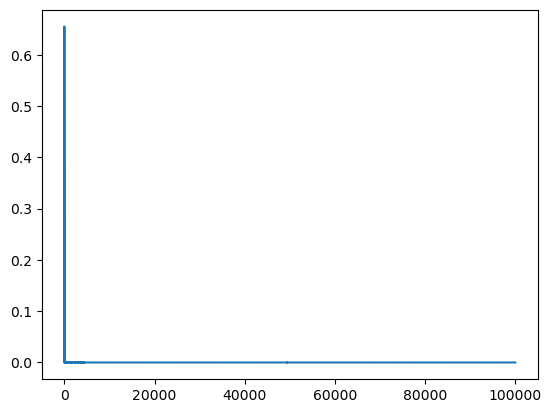

In [ ]:
daq = MyDAQ()
daq.name = 'MyDAQ1'

# Set some basic values
samplerate = 200000
daq.samplerate = samplerate
frequency = 70730
amplitude= 1
duration = 10
delta_f = 100

start_frequency = 1
end_frequency = 80000
frequencies = np.logspace(np.log10(start_frequency), np.log10(end_frequency), 2)
print(frequencies)
# First we generate the signal to go into the circuit
# Here its a simple sine wave
H_mags = []
H_phases = []
sigma_H_mags = []
for frequency in frequencies:
    _, voltages = daq.generateWaveform('sine', samplerate=samplerate, frequency=frequency, amplitude=amplitude, duration=duration)


    # We define which channels to use 
    readChannels = ['AI0' , 'AI1']
    writeChannels = ['AO0']

    # Do the meaurement with MyDAQ
    AI0_voltage, AI1_voltage = daq.readwrite(voltages=voltages, readChannels=readChannels, writeChannels=writeChannels)

    voltage_in = AI0_voltage # Easier to define this way. THe first input channel is the voltage we put in the breadboard
    voltage_out = AI1_voltage # The second input channel is the voltage out over the breadboard component


    # we can now perform the FFT
    freqs_in, fft_in = daq.performRFFT(voltage_in, samplerate)
    freqs_out, fft_out = daq.performRFFT(voltage_out, samplerate)


    # First we calculate the mangitude transfer function
    power_in = daq.power(freqs_in, fft_in, frequency, delta_f)
    power_out = daq.power(freqs_out, fft_out, frequency, delta_f)

    H_mag = np.sqrt(power_out / power_in)

    
        
    #get the power by integrating over the interval
    interval1 = (freqs_out < (frequency - delta_f) ) & (freqs_out > 10)
    interval2 =  (freqs_out > (frequency + delta_f))
    SNR = power_out / (integrate.trapz(np.abs(fft_out[interval1])**2, freqs_out[interval1]) + integrate.trapz(np.abs(fft_out[interval2])**2, freqs_out[interval2]))	

    sigma_power = power_out / np.sqrt(SNR)
    sigma_H_mag =sigma_power / (2 * np.sqrt(power_out))
    # Now we calculate the phase transfer function
    
    index = np.abs(fft_in - frequency).argmin() # Index closest to the frequency of interest
    phase_in =  np.angle(fft_in[index])
    phase_out = np.angle(fft_out[index])

    H_phase = (np.rad2deg(phase_out - phase_in))
    if H_phase > 50:
        H_phase -= 360 

    H_mags.append(H_mag)
    H_phases.append(H_phase)
    sigma_H_mags.append(sigma_H_mag)
    print(sigma_H_mag)
    plt.plot(freqs_out, np.abs(fft_out))
    plt.show()


sigma_H_mags = np.array(sigma_H_mags)
H_mags = np.array(H_mags)
H_phases = np.array(H_phases)
# Now we plot the results
plt.errorbar(frequencies, 20*np.log10(H_mags), yerr=20*sigma_H_mags/(np.log(10) * H_mags), fmt='o')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.xscale('log')
plt.show()
plt.scatter(frequencies, H_phases)
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.ylabel('Phase [Degrees]')
plt.show()





# We

# Debuq time!!!
print(f'{frequency}Hz, Power in: {power_in:.2f}, Power out: {power_out:.2f}')

print(f'H_mag: {H_mag:.2f}, Gain:{20*np.log10(H_mag):.2f}dB')
print(f'H_phase: {H_phase:.2f}')

    